In [1]:
import numpy as np
import pandas as pd
import glob as glob
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
plt.style.use('fivethirtyeight')
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Show/Hide Code</a>.''')

In [70]:
def get_meridios_quality_history_csv(provider, csv):
    df = pd.read_csv(csv, usecols=["lastupdate", "metricname", "ptsseen_avg"], parse_dates=["lastupdate"])
    df['Provider'] = provider.replace("_", " ")
    # Normalize last update to just a date (not specific run time)
    df['lastupdate'] = df['lastupdate'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day))
    return df

def basic_trendline(dataframe, chart, column, metrictitle, threshold):
    dataframe[column].plot(ax=chart, legend=False)
    chart.set(title=metrictitle, ylim=(0,100), xlabel="")
    chart.axhline(y=threshold, color='g', label='Target', linestyle='--', linewidth=1)
    chart.xaxis.set_major_formatter(plt.NullFormatter())
    
def create_individual_core_quality_graphs(individual, clinic):
    dfs = []
    dfs.append(get_meridios_quality_history_csv('FCN',"FCN.csv"))
    dfs.append(get_meridios_quality_history_csv(clinic, ('./clinic/' + clinic + '.csv')))
    dfs.append(get_meridios_quality_history_csv(individual, ('./provider/' + individual + '.csv')))   
    big_frame = pd.concat(dfs, ignore_index=True)
    big_frame = big_frame.pivot_table(index='lastupdate', columns=['metricname','Provider'], values="ptsseen_avg")
    
    # Summary Graph
    fig, ax = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(9,9))
    fig.suptitle(individual.replace('_'," ") + ": Core Quality Measures", fontsize=24)
    
    basic_trendline(big_frame, ax[0][0], "PAP", "Pap", 85)
    basic_trendline(big_frame, ax[0][1], "MAMMO", "Mammogram", 78)
    basic_trendline(big_frame, ax[0][2], "COLORECTAL", "Colorectal", 76)
    
    basic_trendline(big_frame, ax[1][0], "DM-EYE", "Retinopathy (DM)", 76)
    basic_trendline(big_frame, ax[1][1], "DM-FOOT", "Neuropathy (DM)", 77)
    basic_trendline(big_frame, ax[1][2], "DM-KIDNEY", "Nephropathy (DM)", 80)

    basic_trendline(big_frame, ax[2][0], "TDAP", "Tdap", 80)
    basic_trendline(big_frame, ax[2][1], "DM-PPSV", "Pneumovax (DM)", 80)
    ax[2][1].legend(loc="lower right", bbox_to_anchor=(2.2,0.2))
    ax[2][2].axis('off')
    plt.figtext(0.93,0.37,'2017 Q1 through Q3',fontsize=14,ha='right')

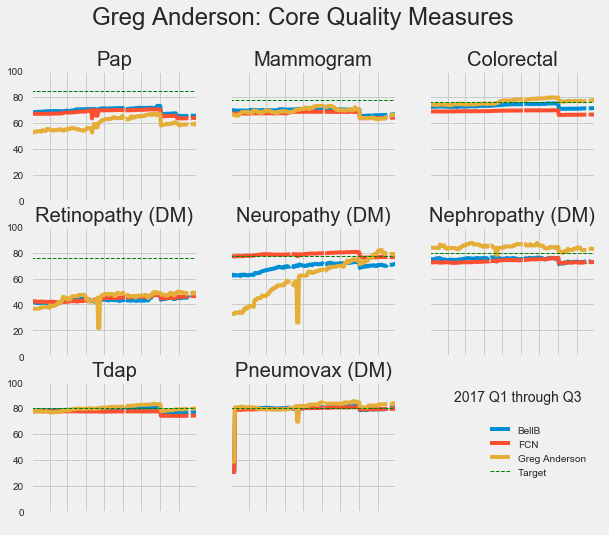

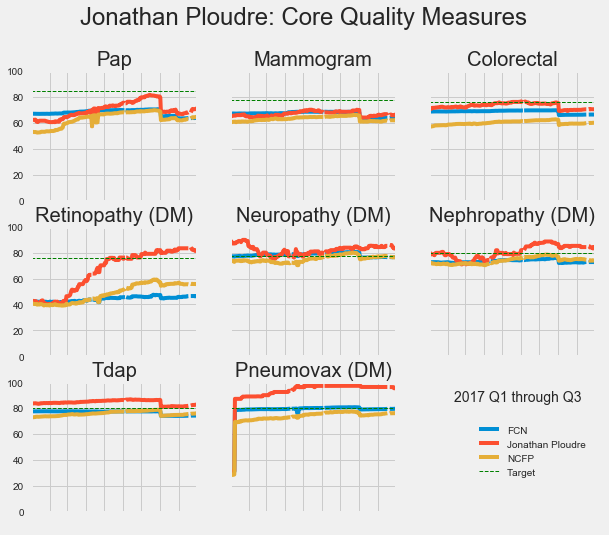

In [71]:
create_individual_core_quality_graphs("Greg_Anderson", "BellB")
create_individual_core_quality_graphs("Jonathan_Ploudre", "NCFP")

ValueError: left cannot be >= right

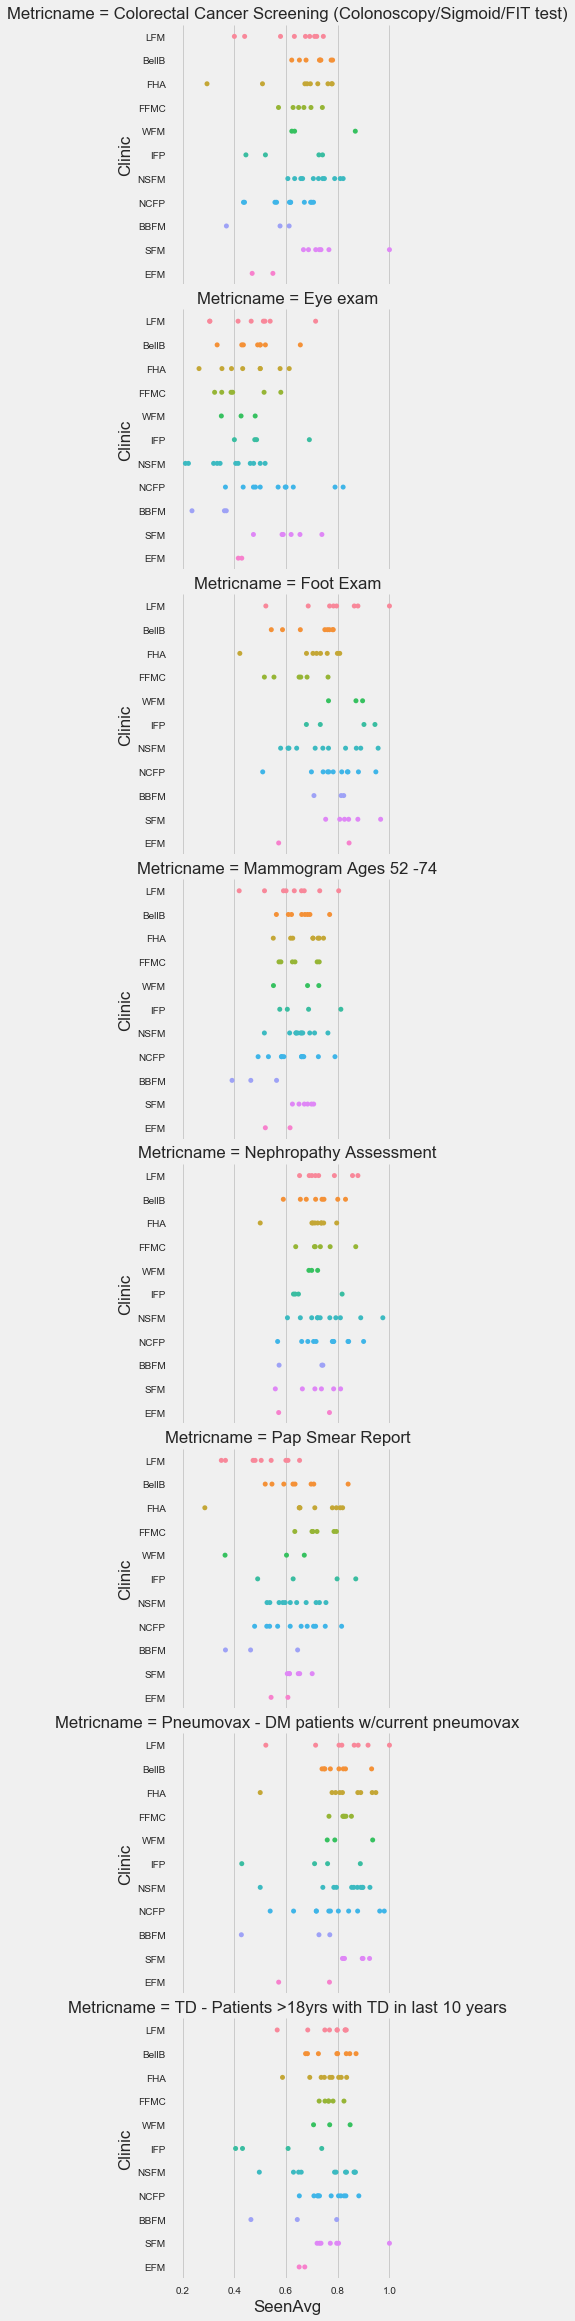

In [29]:
currentdata = pd.read_csv('./current/ProviderGroupQualityReports.csv', usecols=['NAME', 'Metricname', 'SeenAvg'])

# Add Clinic Column with lookup
providerlookup = pd.read_csv('./current/provider-clinic.csv', index_col='NAME')
currentdata['Clinic']=currentdata.NAME.map(providerlookup.CLINIC)

# Remove Clinic Data from Dataframe
#currentdata.NAME.unique()
individuals = currentdata.loc[~currentdata['NAME'].isin(['Bellingham Bay Medical Center','Birch Bay Family Medicine','Everson Family Medicine','Family Health Associates','Ferndale Family Medical Center','Island Family Physicians','Lynden Family Medicine', 'North Cascade Family Physicians','North Sound Family Medicine', 'Squalicum Family Medicine','Whatcom Family Medicine'])]

# CoreQuality is a subset of measures
#currentdata.Metricname.unique()
corequality = individuals.loc[individuals['Metricname'].isin(['Pap Smear Report','Colorectal Cancer Screening (Colonoscopy/Sigmoid/FIT test)','Mammogram Ages 52 -74','Eye exam','Foot Exam','Nephropathy Assessment','TD - Patients >18yrs with TD in last 10 years','Pneumovax - DM patients w/current pneumovax'])]
corequality.Metricname.unique()
sns.factorplot(x='SeenAvg', y='Clinic', data=corequality, row='Metricname', kind="strip")